In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

plt.style.use('ggplot')

# Read example Tarland data

In [2]:
# Download Tarland data into a Pandas dataframe
data_url = r'https://raw.githubusercontent.com/JamesSample/enviro_mod_notes/master/data/Tarland_Flow_And_Met_Data.csv'
met_df = pd.read_csv(data_url, parse_dates=True, index_col=0)

# Convert cumecs to mm
cat_area = 51.7E6 # Catchment area in m2
met_df['Runoff_mm'] = met_df['Q_Cumecs']*60*60*24*1000/cat_area
del met_df['Q_Cumecs']

# Linear interpolation of any missing values
met_df.interpolate(method='linear', inplace=True) 

print (met_df.head())

# Calculate annual averages for rainfall, PET and runoff
ann_df = met_df.resample('A').sum()
print ('\nAnnual averages:')
print (ann_df.mean())

            Rainfall_mm  PET_mm  Runoff_mm
Date                                      
2000-01-01         0.10    0.72   1.297504
2000-01-02         1.00    0.72   1.304857
2000-01-03         1.10    0.72   1.220296
2000-01-04         1.38    0.72   1.155955
2000-01-05         3.62    0.72   1.167152

Annual averages:
Rainfall_mm    965.661818
PET_mm         529.885455
Runoff_mm      458.833117
dtype: float64


# Simple hydrological model

The code below runs the model for a single time step (i.e. constant P and E), but evaluates the ODEs at 1000 intermediate time points. This is the same as the example in [Section 2 of Notebook 5](https://nbviewer.jupyter.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/05_A_Hydrological_Model.ipynb#2.-Solving-ODEs), except I've simplified the ODEs as pointed out by Magnus. If the simplifications work OK for this basic example, they should also work OK for the full model.

In the code below, I've removed the calculation of $\frac{dS}{dt}$ via the Chain Rule and instead calculated values for $S$ explicitly (i.e. outside of the ODE solver) using 

$$S = \frac{(V_s - V_{fc})}{\tau_s(1 + e^{V_{fc} - V_s})}$$

The appears to give the same results (to within floating point error) as my original, and it's certainly simpler (and probably slightly faster?).

                     V         S         G          Ds          Dg
298.798799  340.033391  5.003339  2.715576  471.293478  435.382625
299.099099  340.033391  5.003339  2.716435  471.894479  436.198243
299.399399  340.033391  5.003339  2.717291  472.495481  437.014118
299.699700  340.033391  5.003339  2.718145  473.096483  437.830249
300.000000  340.033391  5.003339  2.718996  473.697484  438.646637


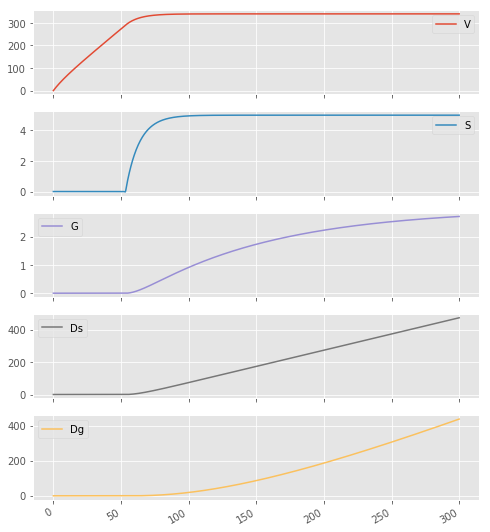

In [3]:
# Example model parameters
alpha = 0.75    # PET correction factor (dimensionless)
beta = 0.6      # BFI (dimensionless)
T_s = 10.       # Soil residence time (days)
T_g = 100.      # Groundwater residence time (days)
fc = 290        # Field capacity (mm)
step_len = 300  # Time step length (days)

# Example initial conditions
P = 8.         # Precipitation (mm/day)
E = 4.         # PET (mm/day)
Vs0 = 0.       # Initial soil volume (mm)
Vg0 = 0.       # Initial groundwater volume (mm)

# Calculate S0 and G0 from Vs0 and Vg0
S0 = (Vs0 - fc)/(T_s*(1 + np.exp(fc - Vs0)))
G0 = Vg0/T_g       

# Array of time points at which to evaluate ODEs
ti = np.linspace(0, step_len, 1000)

def f(y, t, params):
    """ Define ODE system.
            y is list [V, S, G, Ds, Dg]
            t is an array of time points of interest
            params is a tuple (P, E, alpha, beta, T_s, T_g, fc)
    """
    # Unpack incremental values for V and G
    Vi = y[0]
    Gi = y[1]
    
    # Unpack params
    P, E, alpha, beta, T_s, T_g, fc = params

    # Model equations (see section 2.2)
    Si = (Vi - fc)/(T_s*(1 + np.exp(fc - Vi)))        # Calculate Si explicitly, instead of using ODE
    dV_dt = P - alpha*E*(1 - np.exp(-0.02*Vi)) - Si   # Use Si to calculate dV_dt
    dG_dt = (beta*Si - Gi)/T_g
    dDs_dt = (1 - beta)*Si
    dDg_dt = Gi
    
    # Add results of equations to an array
    res = np.array([dV_dt, dG_dt, dDs_dt, dDg_dt])
    
    return res

# Vector of initial conditions
y0 = [Vs0, G0, 0, 0]

# Model parameters
params=[P, E, alpha, beta, T_s, T_g, fc]

# Solve
y = odeint(f, y0, ti, args=(params,))

# Build df from output
df = pd.DataFrame(data=y,
                  columns=['V', 'G', 'Ds', 'Dg'],
                  index=ti)

# Calculate values for S outside of solver using the explicit equation
df['S'] = (df['V'] - fc)/(T_s*(1 + np.exp(fc - df['V'])))

# Reorder columns
df = df[['V', 'S', 'G', 'Ds', 'Dg']]

# Plot
df.plot(subplots=True, figsize=(8, 10))
print (df.tail())